# Libraries

In [1]:
import os
import sys
sys.path.append('/home/kurose/Desktop/master/viu_master_thesis')

import importlib
import models.model_utils

importlib.reload(models.model_utils)
from models.model_utils import load_dataset, get_input_shape, f1_score, get_callbacks, save_and_print_model, get_metrics, plot_metrics

import tensorflow as tf
import keras_tuner as kt
import pandas as pd

tf.random.set_seed(42)

2024-11-07 15:40:20.405723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 15:40:20.557352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 15:40:20.730217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 15:40:20.863732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 15:40:20.907108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 15:40:21.179371: I tensorflow/core/platform/cpu_feature_gu

# Model 3

## Dataset 

In [2]:

train, val, _ = load_dataset(batch_size=2)

## Architecture

In [3]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))

def extract_2d_features_batched(volume_batch):

    extracted_features = []

    for i in range(volume_batch.shape[1]): 
        slice_img = volume_batch[:, i, :, :, :]  # Extract the i-th slice from the batch
        
        # Repeat grayscale channel to simulate 3 channels for the pre-trained model (for each slice)
        slice_img = tf.repeat(slice_img, repeats=3, axis=-1)
        
        # Apply the pre-trained 2D model to the slice
        features = base_model(slice_img)
        extracted_features.append(features)

    # Stack the extracted features along the depth (z-axis) to form a 3D volume of features
    stacked_features = tf.stack(extracted_features, axis=1)
    
    return stacked_features

In [4]:
def model_v3_builder(hp, input_shape):
    volume_input = tf.keras.Input(shape=(input_shape))  
    
    # Lambda Layer
    features = tf.keras.layers.Lambda(extract_2d_features_batched, output_shape=(33, 4, 4, 2048))(volume_input)

    # First Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv1_filters', min_value=2, max_value=4, step=2),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Global Average Pooling 3D instead of Flatten
    x = tf.keras.layers.GlobalAveragePooling3D()(x)

    # Dense Layer
    x = tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=4, max_value=8, step=4),
        activation='relu'
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x) 

    # Output layer
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
    
    # Set Adam Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    )

    # Compile Model
    model = tf.keras.Model(inputs=volume_input, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=get_metrics())

    return model

In [5]:
input_shape = get_input_shape(train)

tuner = kt.BayesianOptimization(
    lambda hp: model_v3_builder(hp, input_shape),
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner',
    project_name='v3'
)

callbacks = get_callbacks(
    checkpoint_path='best_model_v3_tuner.weights.h5',
    monitor_metric='val_accuracy',
    patience=2,
    reduce_factor=0.1,
    reduce_patience=5,
    reduce_min_lr=1e-6)

tuner.search(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = model_v3_builder(best_hps, input_shape)


Trial 5 Complete [00h 09m 06s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.75
Total elapsed time: 01h 13m 20s


In [6]:

trials = tuner.oracle.get_best_trials(num_trials=10)

results = []
for trial in trials:
    trial_info = trial.hyperparameters.values
    trial_info['score'] = trial.score
    results.append(trial_info)

results_df = pd.DataFrame(results)

print(results_df)

   conv1_filters  dense_units  learning_rate  score
0              2            8       0.005189   0.75
1              4            4       0.002112   0.50
2              4            8       0.001307   0.50
3              4            8       0.002852   0.50
4              2            4       0.003188   0.50


In [7]:
print(results_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & conv1_filters & dense_units & learning_rate & score \\
\midrule
0 & 2 & 8 & 0.005189 & 0.750000 \\
1 & 4 & 4 & 0.002112 & 0.500000 \\
2 & 4 & 8 & 0.001307 & 0.500000 \\
3 & 4 & 8 & 0.002852 & 0.500000 \\
4 & 2 & 4 & 0.003188 & 0.500000 \\
\bottomrule
\end{tabular}



In [8]:
save_and_print_model(model, file_path="model_v3_tuner.png")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 33, 4, 4, 2048) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 33, 4, 4, 2)    │       110,594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 4, 4, 2)    │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 33, 4, 4, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 2, 2, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 2, 2, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 2)              │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,635 (432.17 KB)

 Trainable params: 110,631 (432.15 KB)

 Non-trainable params: 4 (16.00 B)

Model architecture saved to model_v3_tuner.png


# Training

In [10]:
callbacks = get_callbacks(
    checkpoint_path='best_model_v3_tuner_final.weights.h5',
    monitor_metric='val_accuracy',
    patience=10,
    reduce_factor=0.1,
    reduce_patience=2,
    reduce_min_lr=1e-6)
              
history = model.fit(train, validation_data=val, epochs=25, callbacks=callbacks)

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6552 - auc: 0.7305 - f1_score: 0.2523 - loss: 0.5147 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 2.3372 - learning_rate: 5.1892e-05
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5978 - auc: 0.3965 - f1_score: 0.4646 - loss: 0.7191 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_f1_score: 0.0000e+00 - val_loss: 1.8136 - learning_rate: 5.1892e-05
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.7160 - auc: 0.8149 - f1_score: 0.2995 - loss: 0.4737 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 1.5884 - learning_rate: 5.1892e-05
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3495 - auc: 0.2482 - f1_score: 0.2142 - loss: 1.2661 

2024-11-07 16:18:03.102769: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3593 - auc: 0.2658 - f1_score: 0.2171 - loss: 1.2456 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 1.4108 - learning_rate: 5.1892e-06
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.6770 - auc: 0.9150 - f1_score: 0.1177 - loss: 0.4804 - val_accuracy: 0.5000 - val_auc: 0.3750 - val_f1_score: 0.0000e+00 - val_loss: 1.3655 - learning_rate: 5.1892e-06
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6844 - auc: 0.6497 - f1_score: 0.2925 - loss: 0.7344 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 1.2049 - learning_rate: 1.0000e-06
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.5857 - auc: 0.6850 - f1_score: 0.2325 - loss: 0.7930 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_f1_score: 0.0000e+00 - val_loss: 1.1105 - learning_rate: 1.0000e-06
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.5501 - auc: 0.6814 - f1_score

Plot saved to model_v3_metrics_tuner.png


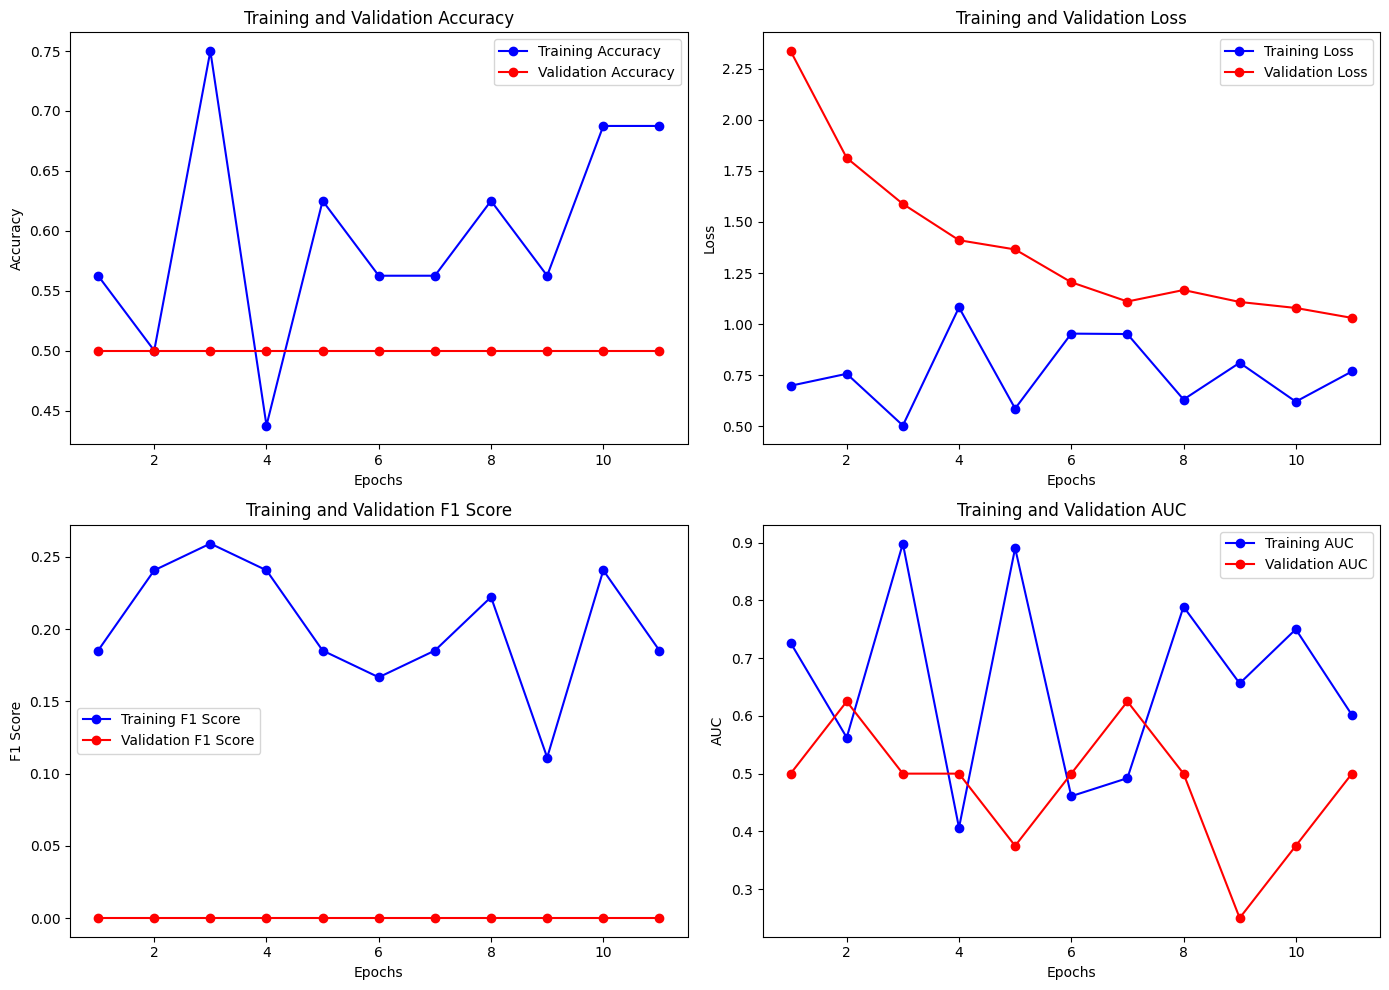

In [12]:
plot_metrics(history, "model_v3_metrics_tuner.png")